In [ ]:
# Import the necessary packages and libraries
import pandas as pd
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
!pip install catboost
import catboost as cb
import matplotlib.pyplot as plt
import os
import joblib
import time
import numpy as np
import random

print(os.environ)
seed = 100
np.random.seed(seed)
random.seed(seed)

environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.5.3.2-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'COLAB_JUPYTER_TRANSPORT': 'ipc', 'NV_NVML_DEV_VERSION': '12.5.82-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn9-cuda-12', 'CGROUP_MEMORY_EVENTS': '/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.22.3-1+cuda12.5', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.22.3-1', 'VM_GCE_METADATA_HOST': '169.254.169.253', 'MODEL_PROXY_HOST': 'https://mp.kaggle.net', 'HOSTNAME': 'd331cd6980e9', 'LANGUAGE': 'en_US', 'TBE_RUNTIME_ADDR': '172.28.0.1:8011', 'COLAB_TPU_1VM': '', 'GCE_METADATA_TIMEOUT': '3', 'NVIDIA_REQUIRE_CUDA': 'cuda>=12.5 brand=unknown,driver>=470,driver<471 brand=grid,driver>=470,driver<471 brand=tesla,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 brand=quadrortx,driver>=470,driver<471 brand=nvidiartx,driver>=470,driver<471 brand=vapps,driver>=470,driver<471 brand=vpc,driver>=47

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from aequitas.group import Group
import pandas as pd

def calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=0.05):
    """
    Calculate the model metrics, including TPR, FPR, threshold and AUROC based on a given FPR limit.

    Args:
    - scored_test (np.array): The predicted scores on the test set.
    - y_test (pd.DataFrame): The test set target variable.
    - fpr_lim (float): The FPR limit to use for obtaining the threshold and TPR. Default is 0.05.

    Returns:
    - metrics_dict (dict): A dictionary containing the TPR, FPR, threshold and AUROC.
    """
    # Calculate the ROC curve points
    fpr, tpr, threshold = roc_curve(y_test, scored_test)

    # Obtain the threshold and TPR based on the FPR
    obtained_tpr = tpr[fpr < fpr_lim][-1]
    obtained_threshold = threshold[fpr < fpr_lim][-1]
    obtained_fpr = fpr[fpr < fpr_lim][-1]

    # Calculate AUROC
    auroc = roc_auc_score(y_test, scored_test)

    # Store the metrics in a dictionary
    metrics_dict = {
        'TPR': round(obtained_tpr, 4),
        'FPR': round(obtained_fpr, 4),
        'Threshold': round(obtained_threshold, 4),
        'AUROC': round(auroc, 4),
    }

    return metrics_dict

def calculate_fairness_metrics(y_test, scored_test, X_test, fpr_lim=0.05):
    """
    Calculate fairness metrics on the predictions.

    Args:
    - scored_test (np.array): The predicted scores on the test set.
    - y_test (pd.Series): The test set target variable.
    - X_test (pd.DataFrame): The test set features.

    Returns:
    - fairness_ratio (float): The fairness ratio.
    """
    # Initialize the fairness evaluator
    g = Group()

    # Calculate the ROC curve points
    fpr, tpr, threshold = roc_curve(y_test, scored_test)

    # Obtain the threshold
    obtained_threshold = threshold[fpr < fpr_lim][-1]

    # Create a DataFrame with the scores, labels, and age
    df = pd.DataFrame({
        "score": scored_test, # Changed to 'score' to align with aequitas' internal sorting
        "label_value": y_test,
        "age": (X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})
    })

    # Calculate the fairness metrics, explicitly passing 'age' as the attribute column
    fairness_metrics = g.get_crosstabs(df, score_thresholds={"score": [obtained_threshold]}, attr_cols=['age'])[0]

    # Calculate the fairness ratio as the min over max in FPR
    fairness_ratio = fairness_metrics["fpr"].min() / fairness_metrics["fpr"].max()

    return round(fairness_ratio, 4)

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

class BAFDataset:
    def load_data(self, file_path):
        """
        Load the specified subset of the BAF dataset as a pandas DataFrame.

        Args:
        - subset (str): The subset to load. Choices are 'Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', and 'Variant V'.

        Returns:
        - df (pd.DataFrame): The BAF dataset as a pandas DataFrame.
        """
        ds_name = file_path.split("/")[-1]  # Split the path by "/" and get the last element
        subset = ds_name.split(".")[0]  # Split the filename by "." and get the first element

        if subset not in ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']:
            raise ValueError("Invalid subset type. Choices are 'Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', and 'Variant V'.")

        df = pd.read_csv(file_path).drop('device_fraud_count', axis=1)
        return df

    def train_test_split(self, df, month):
        """
        Split the BAF dataset into train and test sets based on the specified month.

        Args:
        - df (pd.DataFrame): The BAF dataset as a pandas DataFrame.
        - month (int): The month to use as the splitting point. Months 0-5 are in the train set, and 6-7 are in the test set, as proposed in the paper.

        Returns:
        - (X_train, y_train), (X_test, y_test) (tuple of pd.DataFrame): A tuple containing the train and test sets.
        """
        train_mask = df['month'] < month
        X_train, y_train = df[train_mask].drop(['month', 'fraud_bool'], axis=1), df[train_mask]['fraud_bool']
        X_test, y_test = df[~train_mask].drop(['month', 'fraud_bool'], axis=1), df[~train_mask]['fraud_bool']
        return (X_train, y_train), (X_test, y_test)

    def one_hot_encode_categorical(self, X_train, X_test):
        """
        One-hot encode the categorical features in the BAF dataset.

        This function takes the training and test sets as input, identifies the categorical features
        in the dataset, and one-hot encodes them. The one-hot encoding process converts categorical
        features into binary columns for each category/label. This is done separately for the training
        and test sets to avoid data leakage. The transformed data is then combined with the numerical
        features to form the final one-hot encoded train and test sets.

        Args:
        - X_train (pd.DataFrame): The training set features.
        - X_test (pd.DataFrame): The test set features.

        Returns:
        - X_train, X_test (tuple of pd.DataFrame): The one-hot encoded train and test sets.
        """
        # Identify the categorical features
        s = (X_train.dtypes == 'object')
        object_cols = list(s[s].index)

        # Initialize the one-hot encoder with 'ignore' for handling unknown categories in the test set
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

        # Apply one-hot encoding to the categorical features in the train and test sets
        ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]))
        ohe_cols_test = pd.DataFrame(ohe.transform(X_test[object_cols]))

        # Set the index of the transformed data to match the original data
        ohe_cols_train.index = X_train.index
        ohe_cols_test.index = X_test.index

        # Remove the original categorical features from the train and test sets
        num_X_train = X_train.drop(object_cols, axis=1)
        num_X_test = X_test.drop(object_cols, axis=1)

        # Concatenate the numerical features with the one-hot encoded categorical features
        X_train = pd.concat([num_X_train, ohe_cols_train], axis=1)
        X_test = pd.concat([num_X_test, ohe_cols_test], axis=1)

        # Ensure the column names are strings to meet newer sklearn requirements
        X_train.columns = X_train.columns.astype(str)
        X_test.columns = X_test.columns.astype(str)

        return X_train, X_test

In [ ]:
ds = BAFDataset()

In [ ]:
base_path = "/content/drive/MyDrive/FairFraudDetection/data/raw"
model_path = "/content/drive/MyDrive/FairFraudDetection/models"

variant = "Base.csv"

In [ ]:
# Add file to path
file_path = os.path.join(base_path, variant)

# Load the dataset
df = ds.load_data(file_path)

In [ ]:
# Split the dataset into train and test sets
(X_train, y_train), (X_test, y_test) = ds.train_test_split(df, month=6)

In [ ]:
X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w
0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,...,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1
1,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,...,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1
2,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,...,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1
3,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,...,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1
4,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,...,1,26,0,200.0,0,INTERNET,3.743048,other,0,1


In [ ]:
# One-hot encode the categorical features in the dataset
X_train, X_test = ds.one_hot_encode_categorical(X_train, X_test)

In [ ]:
X_train.head()


,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,16,17,18,19,20,21,22,23,24,25
0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,7850.955007,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,5745.251481,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,5471.988958,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,6755.344479,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,5124.046930,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# define these dictionaries for storing the results
performance_results = {}
fairness_results = {}

# Dictionaries to store training and inference times
training_times_dict = {}
inference_times_dict = {}

In [ ]:
lr_model = LogisticRegression(n_jobs=-1)

In [ ]:
# Start measuring training time
start_time = time.time()

# Training the model
lr_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
lr_training_time = end_time - start_time
print(f"Training Time: {lr_training_time} seconds")
training_times_dict[(variant.split('.')[0], "Logistic Regression")] = {"Training Time":lr_training_time}

Training Time: 35.11730194091797 seconds


In [ ]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
lr_scored_test = lr_model.predict_proba(X_test)[:, 1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
lr_inference_time = end_time - start_time
print(f"Inference Time: {lr_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "Logistic Regression")] = {"Inference Time":lr_inference_time}

Inference Time: 0.05651283264160156 seconds


In [ ]:
import joblib
joblib.dump(lr_model, "/content/drive/MyDrive/FairFraudDetection/models/lr_model.joblib")

['/content/drive/MyDrive/FairFraudDetection/models/lr_model.joblib']

In [ ]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, lr_scored_test, fpr_lim=0.05)
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")
performance_results[(variant.split('.')[0], 'Logistic Regression')] = metrics_dict

Model TPR: 0.205, Model FPR: 0.0499, Model Threshold: 0.1118, Model AUROC: 0.6799


In [ ]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, lr_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'Logistic Regression')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.9049


In [ ]:
rf_model = RandomForestClassifier(n_jobs=-1)


In [ ]:
# Start measuring training time
start_time = time.time()

# Training the model
rf_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
rf_training_time = end_time - start_time
print(f"Training Time: {rf_training_time} seconds")
training_times_dict[(variant.split('.')[0], "Random Forest")] = {"Training Time":rf_training_time}

Training Time: 494.62327122688293 seconds


In [ ]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
rf_scored_test = rf_model.predict_proba(X_test)[:, 1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
rf_inference_time = end_time - start_time
print(f"Inference Time: {rf_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "Random Forest")] = {"Inference Time":rf_inference_time}

Inference Time: 4.040064096450806 seconds


In [ ]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, rf_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'Random Forest')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.434, Model FPR: 0.0413, Model Threshold: 0.09, Model AUROC: 0.8424


In [ ]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, rf_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'Random Forest')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.9235


In [ ]:
import joblib
joblib.dump(lr_model, "/content/drive/MyDrive/FairFraudDetection/models/rf_model.joblib")

['/content/drive/MyDrive/FairFraudDetection/models/rf_model.joblib']

In [ ]:
# XGBoost model
xgb_model = xgb.XGBClassifier()

In [ ]:
# Start measuring training time
start_time = time.time()

# Training the model
xgb_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
xgb_training_time = end_time - start_time
print(f"Training Time: {xgb_training_time} seconds")
training_times_dict[(variant.split('.')[0], "XGBoost")] = {"Training Time":xgb_training_time}

Training Time: 34.92974352836609 seconds


In [ ]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
xgb_scored_test = xgb_model.predict_proba(X_test)[:, 1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
xgb_inference_time = end_time - start_time
print(f"Inference Time: {xgb_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "XGBoost")] = {"Inference Time":xgb_inference_time}

Inference Time: 1.053415060043335 seconds


In [ ]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, xgb_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'XGBoost')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.4858, Model FPR: 0.05, Model Threshold: 0.04050000011920929, Model AUROC: 0.8744


In [ ]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, xgb_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'XGBoost')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.8895


In [ ]:
joblib.dump(lr_model, "/content/drive/MyDrive/FairFraudDetection/models/xg_model.joblib")

['/content/drive/MyDrive/FairFraudDetection/models/xg_model.joblib']

In [ ]:
# CatBoost model
cb_model = cb.CatBoostClassifier(verbose=False)

In [ ]:
# Start measuring training time
start_time = time.time()

# Training the model
cb_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
cb_training_time = end_time - start_time
print(f"Training Time: {cb_training_time} seconds")
training_times_dict[(variant.split('.')[0], "CatBoost")] = {"Training Time":cb_training_time}

Training Time: 329.853639125824 seconds


In [ ]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
cb_scored_test = cb_model.predict_proba(X_test)[:, 1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
cb_inference_time = end_time - start_time
print(f"Inference Time: {cb_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "CatBoost")] = {"Inference Time":cb_inference_time}

Inference Time: 0.2923617362976074 seconds


In [ ]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, cb_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'CatBoost')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.5177, Model FPR: 0.05, Model Threshold: 0.0371, Model AUROC: 0.8829


In [ ]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, cb_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'CatBoost')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.8951


In [ ]:
joblib.dump(lr_model, "/content/drive/MyDrive/FairFraudDetection/models/cat_model.joblib")

['/content/drive/MyDrive/FairFraudDetection/models/cat_model.joblib']

In [ ]:
# Train a model on the data
lgbm_model = lgbm.LGBMClassifier()

In [ ]:
# Start measuring training time
start_time = time.time()

# Training the model
lgbm_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
lgbm_training_time = end_time - start_time
print(f"Training Time: {lgbm_training_time} seconds")
training_times_dict[(variant.split('.')[0], "Light GBM")] = {"Training Time":lgbm_training_time}

[LightGBM] [Info] Number of positive: 8151, number of negative: 786838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.238765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3232
[LightGBM] [Info] Number of data points in the train set: 794989, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010253 -> initscore=-4.569882
[LightGBM] [Info] Start training from score -4.569882
Training Time: 23.072875261306763 seconds


In [ ]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
lgbm_scored_test = lgbm_model.predict_proba(X_test)[:,1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
lgbm_inference_time = end_time - start_time
print(f"Inference Time: {lgbm_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "Light GBM")] = {"Inference Time":lgbm_inference_time}

Inference Time: 1.5817737579345703 seconds


In [ ]:
# Calculate the  TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, lgbm_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'Light GBM')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.525, Model FPR: 0.0498, Model Threshold: 0.0403, Model AUROC: 0.888


In [ ]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, lgbm_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'Light GBM')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.8903


In [ ]:
joblib.dump(lr_model, "/content/drive/MyDrive/FairFraudDetection/models/lbmm_model.joblib")

['/content/drive/MyDrive/FairFraudDetection/models/lbmm_model.joblib']

In [ ]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
isolation_forest = IsolationForest(n_jobs=-1, random_state=seed)


# Start measuring training time
start_time = time.time()

# Train
isolation_forest.fit(X_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
if_training_time = end_time - start_time
print(f"Training Time: {if_training_time} seconds")
training_times_dict[(variant.split('.')[0], "IF")] = {"Training Time":if_training_time}


# Start measuring inference time
start_time = time.time()

# Predict
isolation_scores = isolation_forest.decision_function(X_test)

# End measuring inference time
end_time = time.time()

# Storing and printing the time
if_inference_time = end_time - start_time
print(f"Inference Time: {if_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "IF")] = {"Inference Time":if_inference_time}

Training Time: 1.6079602241516113 seconds
Inference Time: 2.63181209564209 seconds


In [ ]:

# Calculate TPR@5%FPR for Isolation Forest
metrics_dict = calculate_tpr_at_fpr(y_test.values, -isolation_scores, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'IF')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

# Calculate fairness metrics for Isolation Forest
fairness_ratio = calculate_fairness_metrics(y_test.values, -isolation_scores, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'IF')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Model TPR: 0.0785, Model FPR: 0.0499, Model Threshold: 0.0196, Model AUROC: 0.5739
Fairness Ratio: 0.8015 



In [ ]:
# Create a DataFrame from all results
df_performance_results = pd.DataFrame(performance_results).transpose()
df_fairness_results = pd.DataFrame(fairness_results).transpose()
df_training_times_dict = pd.DataFrame(training_times_dict).transpose()
df_inference_times_dict = pd.DataFrame(inference_times_dict).transpose()

In [ ]:
all_results = pd.concat([df_performance_results, df_fairness_results, df_training_times_dict, df_inference_times_dict], axis=1)


In [ ]:
all_results

TPR     FPR  Threshold   AUROC  Fairness Ratio  \
Base Logistic Regression  0.2050  0.0499     0.1118  0.6799          0.9049   
     Random Forest        0.4340  0.0413     0.0900  0.8424          0.9235   
     XGBoost              0.4858  0.0500     0.0405  0.8744          0.8895   
     CatBoost             0.5177  0.0500     0.0371  0.8829          0.8951   
     Light GBM            0.5250  0.0498     0.0403  0.8880          0.8903   
     IF                   0.0785  0.0499     0.0196  0.5739          0.8015   

                          Training Time  Inference Time  
Base Logistic Regression      35.117302        0.056513  
     Random Forest           494.623271        4.040064  
     XGBoost                  34.929744        1.053415  
     CatBoost                329.853639        0.292362  
     Light GBM                23.072875        1.581774  
     IF                        1.607960        2.631812

In [ ]:
# Extract TPR values
lr_tpr = df_performance_results.loc[(variant.split('.')[0], 'Logistic Regression'), 'TPR']
rf_tpr = df_performance_results.loc[(variant.split('.')[0], 'Random Forest'), 'TPR']
xgb_tpr = df_performance_results.loc[(variant.split('.')[0], 'XGBoost'), 'TPR']
cb_tpr = df_performance_results.loc[(variant.split('.')[0], 'CatBoost'), 'TPR']
lgbm_tpr = df_performance_results.loc[(variant.split('.')[0], 'Light GBM'), 'TPR']
if_tpr = df_performance_results.loc[(variant.split('.')[0], 'IF'), 'TPR']
tpr_values = [lr_tpr, rf_tpr, xgb_tpr, cb_tpr, lgbm_tpr, if_tpr]

In [ ]:
# Extract Fairness Ratio values
lr_fn = df_fairness_results.loc[(variant.split('.')[0], 'Logistic Regression'), 'Fairness Ratio']
rf_fn = df_fairness_results.loc[(variant.split('.')[0], 'Random Forest'), 'Fairness Ratio']
xgb_fn = df_fairness_results.loc[(variant.split('.')[0], 'XGBoost'), 'Fairness Ratio']
cb_fn = df_fairness_results.loc[(variant.split('.')[0], 'CatBoost'), 'Fairness Ratio']
lgbm_fn = df_fairness_results.loc[(variant.split('.')[0], 'Light GBM'), 'Fairness Ratio']
if_fn = df_fairness_results.loc[(variant.split('.')[0], 'IF'), 'Fairness Ratio']
fn_values = [lr_fn, rf_fn, xgb_fn, cb_fn, lgbm_fn, if_fn]

In [ ]:
# Extract Training Time values
lr_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'Logistic Regression'), 'Training Time']
rf_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'Random Forest'), 'Training Time']
xgb_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'XGBoost'), 'Training Time']
cb_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'CatBoost'), 'Training Time']
lgbm_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'Light GBM'), 'Training Time']
if_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'IF'), 'Training Time']
tnt_values = [lr_tnt, rf_tnt, xgb_tnt, cb_tnt, lgbm_tnt, if_tnt]

In [ ]:
# Extract Inference Time values
lr_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'Logistic Regression'), 'Inference Time']
rf_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'Random Forest'), 'Inference Time']
xgb_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'XGBoost'), 'Inference Time']
cb_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'CatBoost'), 'Inference Time']
lgbm_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'Light GBM'), 'Inference Time']
if_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'IF'), 'Inference Time']
inf_values = [lr_inf, rf_inf, xgb_inf, cb_inf, lgbm_inf, if_inf]

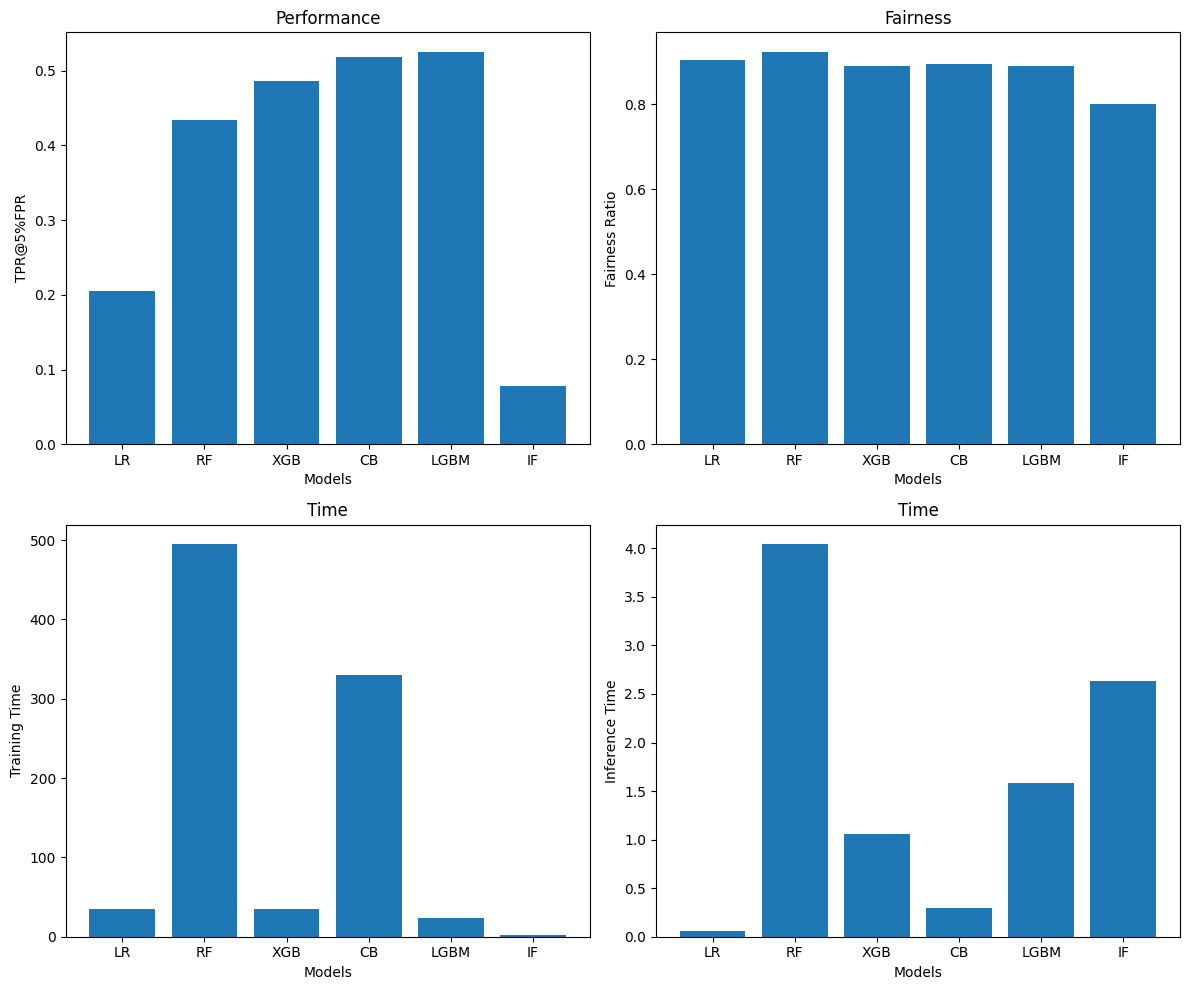

In [ ]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

models = ['LR', 'RF', 'XGB', 'CB', 'LGBM', 'IF']

# Plot TPR values
axs[0, 0].bar(models, tpr_values)
axs[0, 0].set_xlabel('Models')
axs[0, 0].set_ylabel('TPR@5%FPR')
axs[0, 0].set_title('Performance')

# Plot Fairness Ratio values
axs[0, 1].bar(models, fn_values)
axs[0, 1].set_xlabel('Models')
axs[0, 1].set_ylabel('Fairness Ratio')
axs[0, 1].set_title('Fairness')

# Plot Training Time values
axs[1, 0].bar(models, tnt_values)
axs[1, 0].set_xlabel('Models')
axs[1, 0].set_ylabel('Training Time')
axs[1, 0].set_title('Time')

# Plot Inference Time values
axs[1, 1].bar(models, inf_values)
axs[1, 1].set_xlabel('Models')
axs[1, 1].set_ylabel('Inference Time')
axs[1, 1].set_title('Time')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

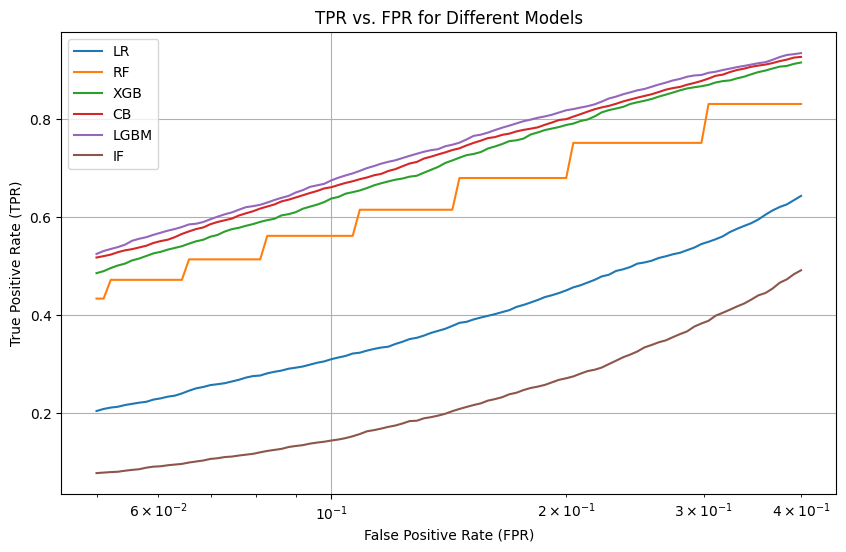

In [ ]:
# Define the list of model names and their corresponding y_scores
model_names = ['LR', 'RF', 'XGB', 'CB', 'LGBM', 'IF']
y_scores_dict = {
    'LR': lr_scored_test,
    'RF': rf_scored_test,
    'XGB': xgb_scored_test,
    'CB': cb_scored_test,
    'LGBM': lgbm_scored_test,
    'IF': -isolation_scores,
}

# Generate FPR values from 5% to 40%
fpr_values = np.logspace(np.log10(0.05), np.log10(0.4), num=100)

# Initialize a dictionary to store interpolated TPR values for each model
interpolated_tpr = {}

# Calculate TPR values for each model at the desired FPR points
for model_name in model_names:
    scored_test = y_scores_dict[model_name]
    tpr_list = [calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=i)['TPR'] for i in fpr_values]
    interpolated_tpr[model_name] = tpr_list

# Plotting
plt.figure(figsize=(10, 6))
for model_name, model_tpr_interp in interpolated_tpr.items():
    plt.plot(fpr_values, model_tpr_interp, label=model_name)

plt.xscale('log')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TPR vs. FPR for Different Models')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Define your custom metric function
def TPR_at_05FPR(y_test, scored_test):
    fpr, tpr, threshold = roc_curve(y_test, scored_test)
    tpr_at_05fpr = tpr[fpr < 0.05][-1]
    return tpr_at_05fpr

# Convert your custom metric function to a scorer object
custom_scorer = make_scorer(TPR_at_05FPR, greater_is_better=True)

# Hyperparameter grids for each model
# Here we only run the hyperparameter tuning for LightGBM
param_grids = {
    "LightGBM": {
        'num_leaves': [10, 25, 50],
        'min_data_in_leaf': [10, 25, 50],
        'max_depth': [1, 3, 5],
        'n_estimators': [50, 100, 200]
    }
}

# define these dictionaries for storing the results
performance_results = {}
fairness_results = {}

# List of models to evaluate
models = {
    "LightGBM": lgbm.LGBMClassifier()
}

# Instantiate the BAF class
ds = BAFDataset()

# set the path to the dataset and models
base_path = "/content/drive/MyDrive/FairFraudDetection/data/raw"
variant = "Base.csv"

# Add file to path
file_path = os.path.join(base_path, variant)

# Load the dataset
df = ds.load_data(file_path)

# Split the dataset into train and test sets for the current variant
(X_train, y_train), (X_test, y_test) = ds.train_test_split(df, month=6)

# One-hot encode the categorical features in the dataset
X_train, X_test = ds.one_hot_encode_categorical(X_train, X_test)

# Loop over models
for model_name, model in models.items():
    print(f"Hyperparameter tuning for {model_name} on {variant.split('.')[0]}...")

    # Initialize dictionaries to store results
    performance_results[(variant.split('.')[0], model_name)] = {}
    fairness_results[(variant.split('.')[0], model_name)] = {}

    # Perform hyperparameter tuning using GridSearchCV
    param_grid = param_grids[model_name]
    # scoring should be 'roc_auc' if you want to optimize for AUROC
    # Here we want to maximize TPR@5%FPR
    search = GridSearchCV(model, param_grid, scoring=custom_scorer, cv=5, verbose=0)
    search.fit(X_train, y_train)

    # Get the best model with tuned hyperparameters
    best_model = search.best_estimator_

    # Train the best model
    best_model.fit(X_train, y_train)

    # Predict on the test set using the best model
    scored_test = best_model.predict_proba(X_test)[:, 1]

    # Calculate the TPR@5%FPR on the test set
    metrics_dict = calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=0.05)
    performance_results[(variant.split('.')[0], model_name)] = metrics_dict
    print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

    # Calculate the fairness metrics on the test set
    fairness_ratio = calculate_fairness_metrics(y_test, scored_test, X_test, fpr_lim=0.05)
    fairness_results[(variant.split('.')[0], model_name)]["Fairness Ratio"] = fairness_ratio
    print(f"Fairness Ratio: {fairness_ratio}", "\n")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Access the best hyperparameters
best_hyperparameters = search.best_params_
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: {'max_depth': 5, 'min_data_in_leaf': 10, 'n_estimators': 200, 'num_leaves': 10}


In [ ]:
df_performance_results = pd.DataFrame(performance_results).transpose()
df_performance_results

,,TPR,FPR,Threshold,AUROC
Base,LightGBM,0.5306,0.05,0.0441,0.8914


In [ ]:
df_fairness_results = pd.DataFrame(fairness_results).transpose()
df_fairness_results

,,Fairness Ratio
Base,LightGBM,0.8922


In [ ]:
# Instantiate the BAF class
ds = BAFDataset()

# set the path to the dataset and models
base_path = "/content/drive/MyDrive/FairFraudDetection/data/raw"
model_path = "/content/drive/MyDrive/FairFraudDetection/models"

# define these dictionaries for storing the results
performance_results = {}
fairness_results = {}

# Dictionaries to store training and inference times
training_times_dict = {}
inference_times_dict = {}

# List of variants and their corresponding file names
variants = {
    'Variant I': 'Variant I.csv',
    'Variant II': 'Variant II.csv',
    'Variant III': 'Variant III.csv',
    'Variant IV': 'Variant IV.csv',
    'Variant V': 'Variant V.csv',
}

# List of models to evaluate
models = {
    "LightGBM": lgbm.LGBMClassifier(),
}

# Loop over variants and models
for variant, file_name in variants.items():
    print(f"Loading data for {variant}...")

    # Load data from CSV file
    df = pd.read_csv(os.path.join(base_path, file_name))

    # Split the dataset into train and test sets for the current variant
    (X_train, y_train), (X_test, y_test) = ds.train_test_split(df, month=6)

    # One-hot encode the categorical features in the dataset
    X_train, X_test = ds.one_hot_encode_categorical(X_train, X_test)

    # Loop over models
    for model_name, model in models.items():
        print(f"Training and evaluating {model_name} on {variant}...")

        # Initialize dictionaries to store results
        training_times_dict[(variant, model_name)] = {}
        inference_times_dict[(variant, model_name)] = {}
        performance_results[(variant, model_name)] = {}
        fairness_results[(variant, model_name)] = {}

        # Start measuring training time
        start_time = time.time()

        # Train the model
        model.fit(X_train, y_train)

        # End measuring training time
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training Time: {training_time} seconds")
        training_times_dict[(variant, model_name)]["Training Time"] = training_time

        # Save the model
        path_to_model = os.path.join(model_path, f"{variant}_{model_name.replace(' ', '_').lower()}_model.joblib")
        joblib.dump(model, path_to_model)

        # Start measuring inference time
        start_time = time.time()

        # Predict on the test set
        scored_test = model.predict_proba(X_test)[:, 1]

        # End measuring inference time
        end_time = time.time()
        inference_time = end_time - start_time
        print(f"Inference Time: {inference_time} seconds")
        inference_times_dict[(variant, model_name)]["Inference Time"] = inference_time

        # Calculate the TPR@5%FPR on the test set
        metrics_dict = calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=0.05)
        print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")
        performance_results[(variant, model_name)] = metrics_dict

        # Calculate the fairness metrics on the test set
        fairness_ratio = calculate_fairness_metrics(y_test, scored_test, X_test, fpr_lim=0.05)
        fairness_results[(variant, model_name)]["Fairness Ratio"] = fairness_ratio
        print(f"Fairness Ratio: {fairness_ratio}", "\n")
    print('\n\n')

Loading data for Variant I...
Training and evaluating LightGBM on Variant I...
[LightGBM] [Info] Number of positive: 8151, number of negative: 786839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.616195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3232
[LightGBM] [Info] Number of data points in the train set: 794990, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010253 -> initscore=-4.569883
[LightGBM] [Info] Start training from score -4.569883
Training Time: 30.6590678691864 seconds
Inference Time: 2.6817874908447266 seconds
Model TPR: 0.499, Model FPR: 0.05, Model Threshold: 0.0409, Model AUROC: 0.8838
Fairness Ratio: 0.9782 




Loading data for Variant II...
Training and evaluating LightGBM on Variant II...
[LightGBM] [Info] Number of positive: 8151, number of negative: 786839
[LightGBM] [Info] A

In [ ]:
# Create a DataFrame from all results
df_performance_results = pd.DataFrame(performance_results).transpose()
df_fairness_results = pd.DataFrame(fairness_results).transpose()
df_training_times_dict = pd.DataFrame(training_times_dict).transpose()
df_inference_times_dict = pd.DataFrame(inference_times_dict).transpose()

In [ ]:
all_results = pd.concat([df_performance_results, df_fairness_results, df_training_times_dict, df_inference_times_dict], axis=1)


In [ ]:
all_results

,,TPR,FPR,Threshold,AUROC,Fairness Ratio,Training Time,Inference Time
Variant I,LightGBM,0.4990,0.0500,0.0409,0.8838,0.9782,30.659068,2.681787
Variant II,LightGBM,0.5295,0.0499,0.0416,0.8938,0.9130,19.625593,1.522472
Variant III,LightGBM,0.7304,0.0500,0.0259,0.9481,0.9244,18.385631,1.877770
Variant IV,LightGBM,0.4016,0.0500,0.0427,0.8435,0.9148,18.492300,2.478854
Variant V,LightGBM,0.3311,0.0500,0.0265,0.7777,0.9309,19.248905,1.807205
